# About
Hello there! In this notebook, I trained a Mobile Net V2 for multiple class image classification. The images on the dataset is about animals. I also use the T4 x2 GPU from Kaggle to trained the model to make the training time faster. I will also demonstrate how to perform callbacks during training, and export the model into TF-Lite, Tensorflow JS, and Saved Model.

# Import Libraries

In [1]:
!pip install split-folders

In [2]:
!pip install -q tensorflow

In [3]:
!pip install -q matplotlib

In [4]:
!pip install -q numpy

In [5]:
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [6]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import splitfolders

import kagglehub
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import cv2
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-04-21 12:43:57.136829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745239437.361469      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745239437.428000      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# GPU Preparation

In [8]:
!nvidia-smi

Mon Apr 21 12:44:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

I0000 00:00:1745239452.357867      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745239452.358589      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
print(f"Number of GPUs Available: {strategy.num_replicas_in_sync}")

Number of GPUs Available: 2


In [11]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Data Preparation

## Data Loading

In [12]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [13]:
ds_dir = '/kaggle/input/animals10/raw-img'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3

In [14]:
#count total images in the dataset
def count_images(directory, extensions=('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
    total_img = 0
    # os.walk traverses all subdirectories
    for root, dirs, files in os.walk(directory):
        # Filter files that match common image extensions
        img_files = [file for file in files if file.lower().endswith(extensions)]
        total_img += len(img_files)
    return total_img

total = count_images(ds_dir)
print("Total images:", total)

Total images: 26179


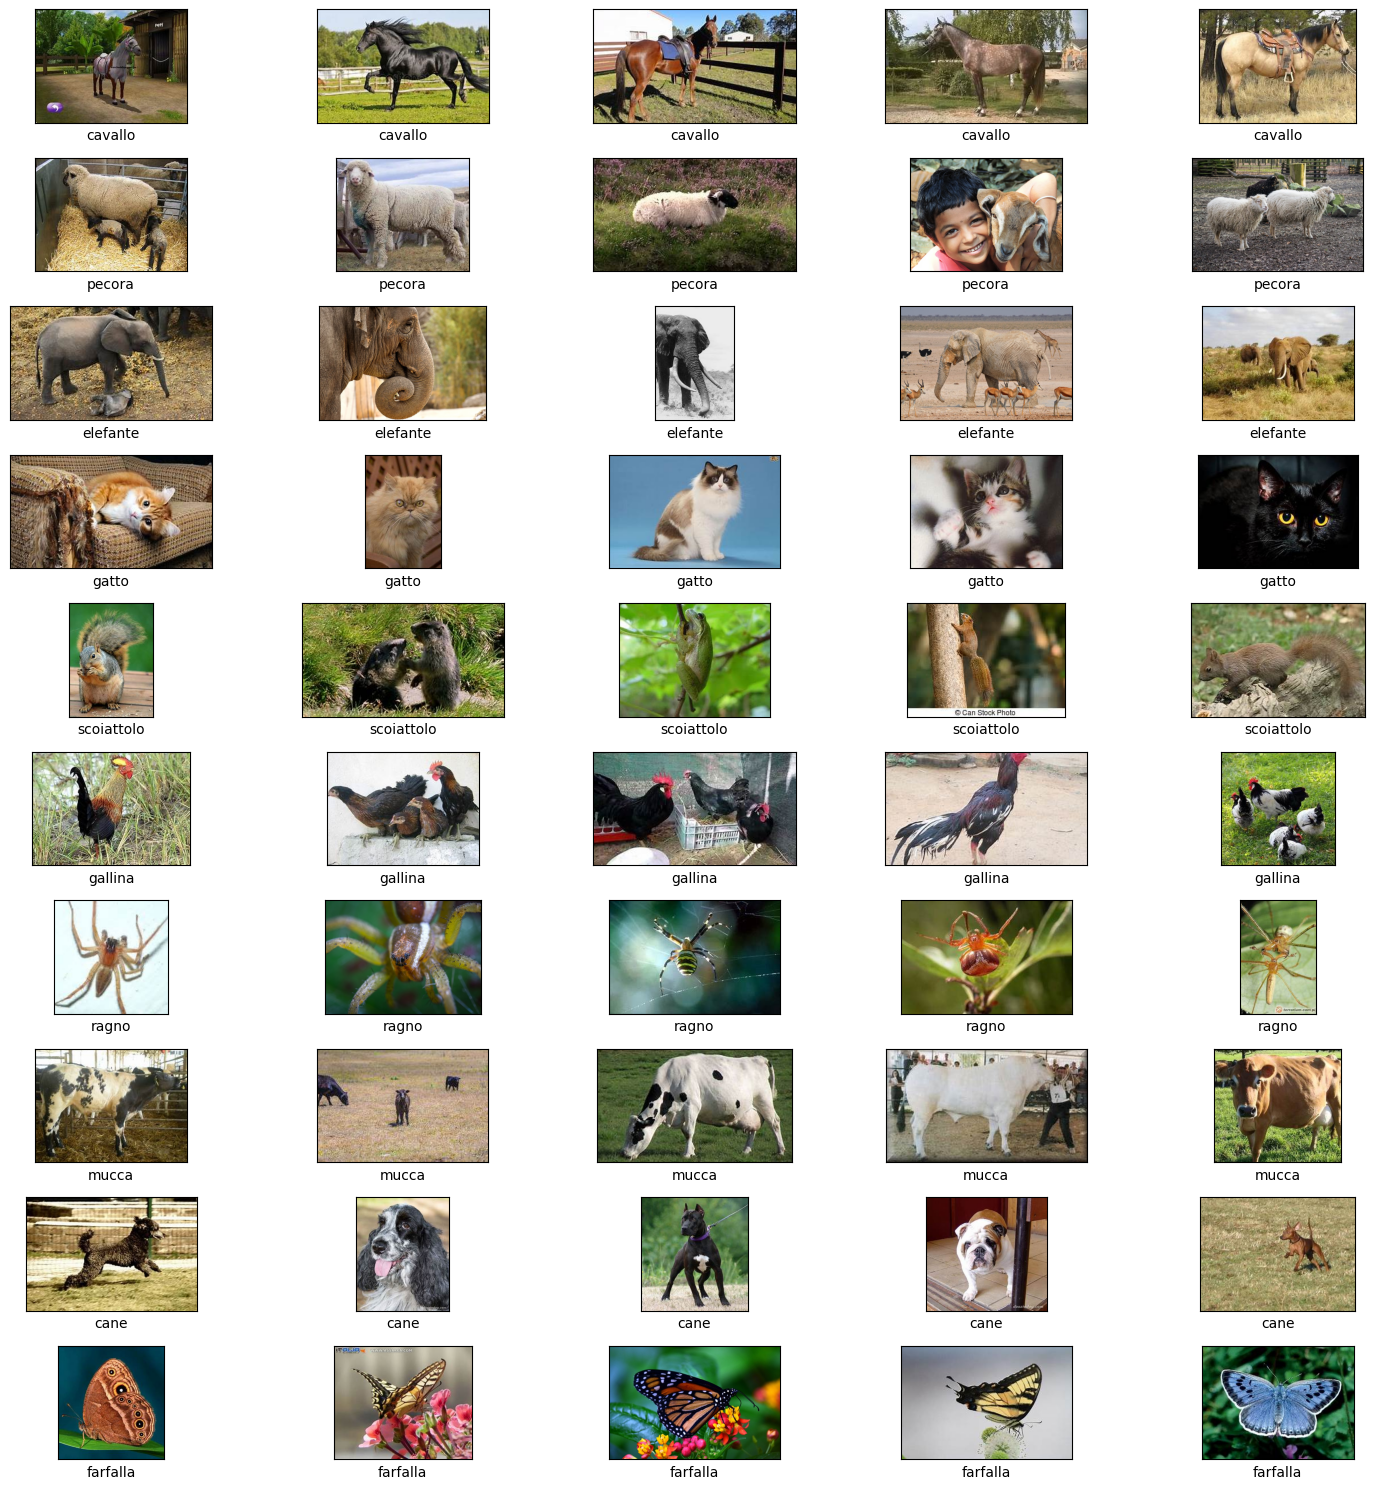

In [15]:
# Create a dictionary that stores images for each class in the data.
animal_image = {}

# Specify the dataset's source path
path = "/kaggle/input/animals10/"
path_sub = os.path.join(path, "raw-img")
for i in os.listdir(path_sub):
    animal_image[i] = os.listdir(os.path.join(path_sub, i))

# Randomly display 5 images under each of the 2 classes of data.
# You will see a different image each time this code is run.
path_sub = "/kaggle/input/animals10/raw-img/"

# Randomly display 5 images under each class from the training data
fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

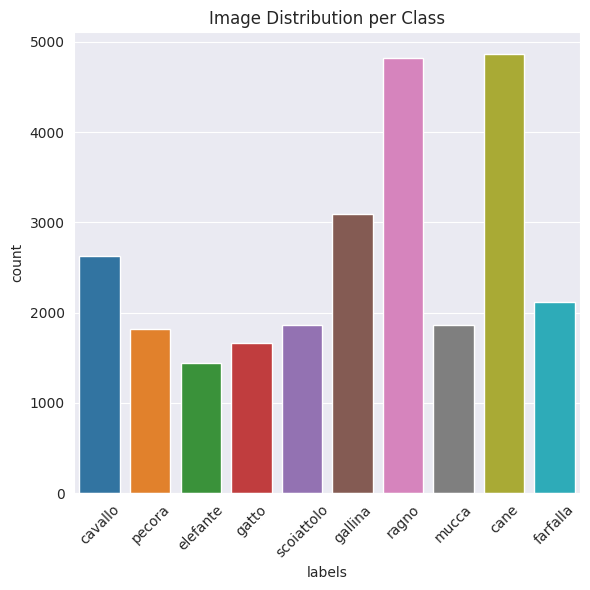

In [16]:
# Specify the dataset's source path
animal_path = "/kaggle/input/animals10/raw-img"

# Create a list that stores data for each file name, file path, and label in the data
file_name = []
labels = []
full_path = []

# Get the image file name, file path, and label one by one by looping, and save it as a dataframe.
for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Distribution plot of images in each class
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x="labels", data=distribution_train)
plt.xticks(rotation=45)  # Optional: rotasi label biar gak numpuk
plt.title("Image Distribution per Class")
plt.tight_layout()
plt.show()

Even though the images distirbution in each class is imbalanced, I think it is okay. Because in the smallest dataset "elefante" it have 1000s images. We will see how the model handle it in model evaluation.

## Data Preprocessing

### Split Dataset

In [17]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(ds_dir, output="splitted_dataset",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 26179 files [03:00, 144.69 files/s]


In [18]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        fill_mode='nearest',
        horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
        'splitted_dataset/train',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 20938 images belonging to 10 classes.


In [19]:
validation_datagen = ImageDataGenerator(
        rescale=1./255
        )
validation_generator = validation_datagen.flow_from_directory(
        'splitted_dataset/val',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 2614 images belonging to 10 classes.


In [20]:
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

test_generator = test_datagen.flow_from_directory(
        'splitted_dataset/test',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 2627 images belonging to 10 classes.


In [21]:
train_generator.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [22]:
class_names = list(train_generator.class_indices.keys())
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

So, there are 10 classes in the dataset. However, it seems that the class labels are not English, but Spanish. I will change the class labels to English later.

# Modelling

In [23]:
mobile_net_base = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
for layer in mobile_net_base.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
with strategy.scope():
    # Model architecture
    model = tf.keras.models.Sequential([
        mobile_net_base,
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    # Fit model
    history = model.fit(
        train_generator,
        epochs=28,
        validation_data=validation_generator,
        callbacks=[early_stopping, lr_reduction]
    )


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/28


E0000 00:00:1745239704.895112      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745239708.575754     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745239708.575774     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


655/655 ━━━━━━━━━━━━━━━━━━━━ 232s 335ms/step - accuracy: 0.7233 - loss: 0.9248 - val_accuracy: 0.9074 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 2/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 218s 329ms/step - accuracy: 0.8737 - loss: 0.4573 - val_accuracy: 0.9235 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 3/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 216s 326ms/step - accuracy: 0.8968 - loss: 0.3602 - val_accuracy: 0.9419 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 4/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 217s 328ms/step - accuracy: 0.8974 - loss: 0.3684 - val_accuracy: 0.9388 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 5/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 217s 328ms/step - accuracy: 0.9138 - loss: 0.3230 - val_accuracy: 0.9235 - val_loss: 0.2989 - learning_rate: 0.0010
Epoch 6/28
654/655 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9168 - loss: 0.2827
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
655/655 ━━━━━━━━━━━━━━━━━━━━ 217s 328ms/step - accuracy: 0.9168 - l

# Evaluasi dan Visualisasi

In [25]:
if early_stopping.stopped_epoch > 0:
    stop_epoch = early_stopping.stopped_epoch - 5
else:
    stop_epoch = len(history.history['loss']) - 1  # Last epoch index

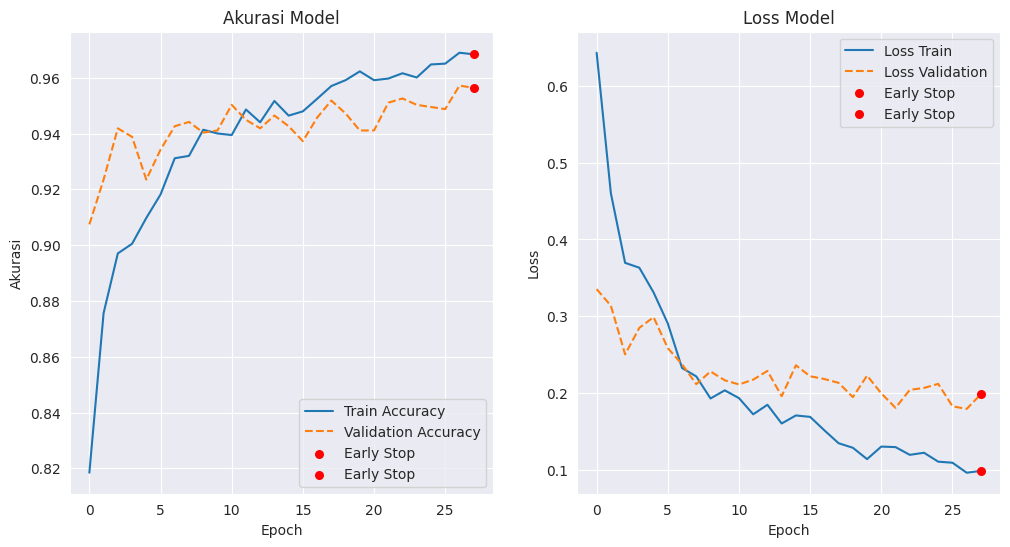

In [26]:
# Create the plots
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
# Add a red dot at the stopping epoch on the validation accuracy curve
plt.scatter(stop_epoch, history.history['accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Validation', linestyle='--')
# Add a red dot at the stopping epoch on the validation loss curve
plt.scatter(stop_epoch, history.history['loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
plt.savefig('model_evaluation_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [28]:
true_classes = []
predicted_classes = []

for images, labels in test_generator:
    predictions = model.predict(images)
    predicted_classes_batch = np.argmax(predictions, axis=1)

    true_classes.extend(labels)
    predicted_classes.extend(predicted_classes_batch)

    if len(true_classes) >= test_generator.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [29]:
translate = {"cane": "Dog",
             "cavallo": "Horse",
             "elefante": "Elephant",
             "farfalla": "Butterfly",
             "gallina": "Hen",
             "gatto": "Cat",
             "mucca": "Cow",
             "pecora": "Sheep",
             "ragno": "Spider",
             "scoiattolo": "Squirrel",
             "Dog": "cane",
             "Horse": "cavallo",
             "Elephant" : "elefante",
             "Butterfly": "farfalla",
             "Hen": "gallina",
             "Cat": "gatto",
             "Cow": "mucca",
             "Sheep": "pecora",
             "Spider": "ragno",
             "Squirrel": "scoiattolo"}

In [30]:
#change the class label to english
original_labels = [label for label, idx in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
translated_labels = [translate.get(label, label) for label in original_labels]

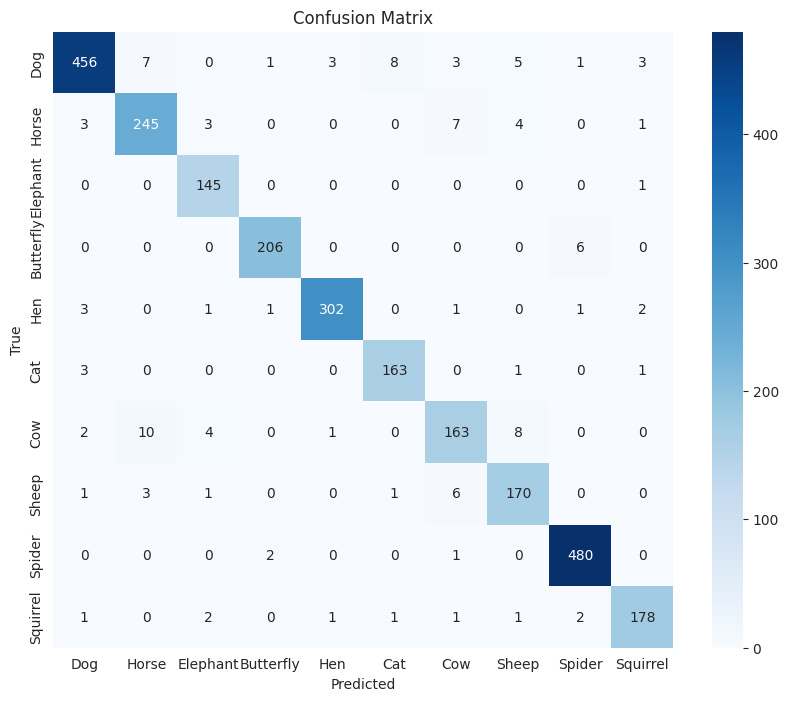

In [31]:
# make confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt_cm = plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=translated_labels, yticklabels=translated_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [32]:
plt_cm.savefig('plt_cm.png', dpi=300, bbox_inches='tight')

In [33]:
# check f1-score, recall, precission, and support
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(translated_labels)))

Classification Report:
              precision    recall  f1-score   support

         Dog       0.97      0.94      0.95       487
       Horse       0.92      0.93      0.93       263
    Elephant       0.93      0.99      0.96       146
   Butterfly       0.98      0.97      0.98       212
         Hen       0.98      0.97      0.98       311
         Cat       0.94      0.97      0.96       168
         Cow       0.90      0.87      0.88       188
       Sheep       0.90      0.93      0.92       182
      Spider       0.98      0.99      0.99       483
    Squirrel       0.96      0.95      0.95       187

    accuracy                           0.95      2627
   macro avg       0.95      0.95      0.95      2627
weighted avg       0.95      0.95      0.95      2627



In [34]:
# Evaluate the training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Training Accuracy:", train_accuracy)

# Evaluate the testing
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.986436128616333


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 0.9611872434616089


# Export and Conveert Model

In [35]:
model.save("/kaggle/working/saved_model.keras")

In [36]:
model.export('/kaggle/working/saved_model')

Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135042919199376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919198032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919198608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919199568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919200336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919198224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919197072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919197456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919198416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135042919200144: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [37]:
# check the folder
tflite_dir = "/kaggle/working/tflite"
os.makedirs(tflite_dir, exist_ok=True)

# convert to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/saved_model')
tflite_model = converter.convert()

# save tflite model
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Save the label
class_names = sorted(translated_labels)
with open("/kaggle/working/tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

W0000 00:00:1745246051.300902      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745246051.300966      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745246051.418529      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [38]:
tfjs_target_dir = "/kaggle/working/tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


# Inference

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


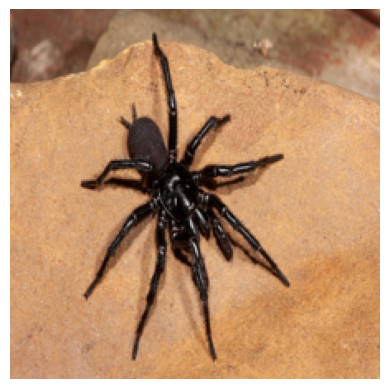

🔍 Predicted Label: Spider
✅ Confidence Value: 1.00


In [39]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/tflite/model.tflite")
interpreter.allocate_tensors()

# Input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
img_size = (224, 224)

# Labels
labels = [
    'Dog',
    'Horse',
    'Elephant',
    'Butterfly',
    'Hen',
    'Cat',
    'Cow',
    'Sheep',
    'Spider',
    'Squirrel'
]

# Upload image
image_path = "/kaggle/input/animal10-test/630d9b29535be.jpg"

img = Image.open(image_path).convert('RGB')
img = img.resize(img_size)
input_data = np.expand_dims(img, axis=0).astype(np.float32)
input_data /= 255.0

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index]
confidence = output_data[predicted_index]

# Show result of the prediction and the image
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"🔍 Predicted Label: {predicted_label}")
print(f"✅ Confidence Value: {confidence:.2f}")

# Archiving the folder project to zip

In [41]:
!zip -r /kaggle/working/result.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/saved_model/ (stored 0%)
updating: kaggle/working/saved_model/variables/ (stored 0%)
updating: kaggle/working/saved_model/variables/variables.index (deflated 78%)
updating: kaggle/working/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: kaggle/working/saved_model/assets/ (stored 0%)
updating: kaggle/working/saved_model/saved_model.pb (deflated 91%)
updating: kaggle/working/saved_model/fingerprint.pb (stored 0%)
updating: kaggle/working/model_evaluation_plot.png (deflated 98%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/tflite/ (stored 0%)
updating: kaggle/working/tflite/model.tflite (deflated 7%)
updating: kaggle/working/tflite/label.txt (deflated 2%)
updating: kaggle/working/tfjs_model/ (stored 0%)
updating: kaggle/working/tfjs_model/group1-shard3of3.bin (deflated 7%)
updating: kaggle/working/tfjs_model/group1-shard2of3.bin (deflated 7%)
updating: kaggle/work